# ERA5 Forcing Data Visualization 
*This script visualizes ERA5 data over the Southern Rocky Mountains High Altitude Tundra (EPA L4 Ecoregion)*

### TODO
- I would like to aggregate the daily by month (all time steps in each file) and create a map that show trends over the SRM region's tp trends from ERA5.
- Get a monthly average over the whole region and plot the trends over time by variable
- Possibly partition further into zones like San Juans, Sangre de Cristos, Front Range, Never Summer/Rawah/Flattops range, etc.

In [1]:
import gzip
import os
import shutil
import matplotlib.pyplot as plt
import rasterio as rio
import xarray as xr
from rasterio.mask import mask
from rasterio.plot import show

%matplotlib inline

# Pathing and Settings
era_var_dir = "/glade/campaign/cgd/tss/common/lm_forcing/era5land/daily/raw/"
output_data_dir = "/glade/u/home/milesmoore/data/era5_srm/"

In [2]:
# Get list of variables to process
var_list = [var for var in os.listdir(era_var_dir) if "README" not in var]

# Let's do a test run with total_precipitation first
precip_dir = os.path.join(era_var_dir, "total_precipitation")
precip_fns = os.listdir(precip_dir)

# sorted(precip_fns)
# var_list

In [3]:
# Path to the compressed NetCDF file
compressed_file = os.path.join(precip_dir, "total_precipitation.202005.nc.gz")
# Temporary decompressed file path
decompressed_file = os.path.join(output_data_dir, "total_precipitation.202005.nc")

# Decompress the .gz file
with gzip.open(compressed_file, "rb") as f_in:
    with open(decompressed_file, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

In [4]:
# Open dataset
ds = xr.open_dataset(os.path.join(output_data_dir, "total_precipitation.202005.nc"))
print(ds)

<xarray.Dataset>
Dimensions:    (longitude: 581, latitude: 281, time: 31)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.9 -124.8 ... -67.2 -67.1 -67.0
  * latitude   (latitude) float32 53.0 52.9 52.8 52.7 ... 25.3 25.2 25.1 25.0
  * time       (time) datetime64[ns] 2020-05-01 2020-05-02 ... 2020-05-31
Data variables:
    tp         (time, latitude, longitude) float32 ...


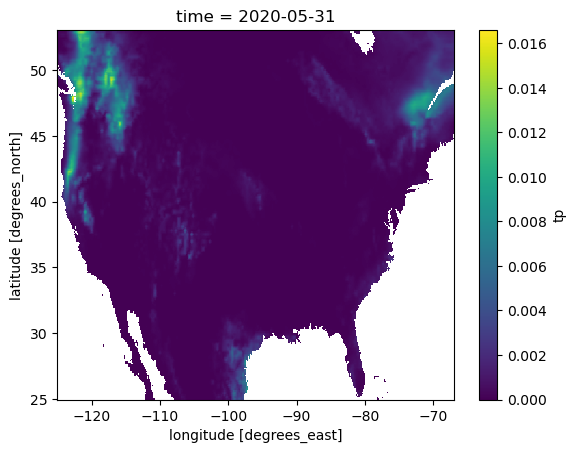

In [5]:
ds["tp"].isel(time=30).plot()

In [6]:
file_path = os.path.join(output_data_dir, "total_precipitation.202005.nc")

# Define the bounding box as a list of GeoJSON-like geometry
# Coordinates are in the order: (lon, lat)
bbox = [
    {
        "type": "Polygon",
        "coordinates": [
            [
                [-109.72405799699105, 35.151713838066904],
                [-103.39593299699105, 35.151713838066904],
                [-103.39593299699105, 42.04553988886985],
                [-109.72405799699105, 42.04553988886985],
            ]
        ],
    }
]

# Use rasterio to open the dataset as a raster image
# You might need to adjust 'var_name' to match the variable in your dataset
with rio.open(file_path) as src:
    out_image, out_transform = mask(src, bbox, crop=True)
    out_meta = src.meta.copy()

# Modify the metadata to match the clipped data
out_meta.update(
    {
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
    }
)

# Save the clipped raster to a new file
clipped_file_path = os.path.join(
    output_data_dir, "clipped_total_precipitation.202005.tif"
)
with rio.open(clipped_file_path, "w", **out_meta) as dest:
    dest.write(out_image)

print(f"Clipped dataset saved to {clipped_file_path}")

Clipped dataset saved to /glade/u/home/milesmoore/data/era5_srm/clipped_total_precipitation.202005.tif


In [7]:
# Open the raster file
with rasterio.open(clipped_file_path) as src:
    # Read the first band
    data = src.read(1)

    # Get the transformation matrix for the dataset
    transform = src.transform

    # Set up the figure
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot the data using the geographical coordinates
    # extent=(left, right, bottom, top)
    img = ax.imshow(
        data,
        cmap="viridis",
        extent=(
            transform[2],
            transform[2] + transform[0] * data.shape[1],
            transform[5] + transform[4] * data.shape[0],
            transform[5],
        ),
        origin="upper",
    )

    # Add a colorbar
    fig.colorbar(img, ax=ax, orientation="vertical", fraction=0.036, pad=0.04)

    # Set labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Raster Data Plot with Geographic Coordinates")

    # Show the plot
    plt.show()

NameError: name 'rasterio' is not defined